# Import package

In [51]:
import os
import math
import time 
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from collections import Counter

# Global variable

In [52]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
label_classes = ['森森', '牛排', '巧巧', '小白', '花捲', '金毛', '吊吊', '黑胖', '乖狗', '橘子']

num_of_class = len(label_classes)
batch_size = 32
target_size = (224, 224)

# Preprocess data

In [53]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# train
train_generator = train_datagen.flow_from_directory(
    directory="data/",
    target_size=target_size,
    color_mode="rgb",
    class_mode='categorical',
    classes=label_classes,
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)
for i, j in Counter(train_generator.classes).items():
    print(f"{label_classes[i]} with {j:3d} images")
print()

# valid
valid_generator = train_datagen.flow_from_directory(
    directory="data/",
    target_size=target_size,
    color_mode="rgb",
    class_mode='categorical',
    classes=label_classes,
    batch_size=batch_size,
    shuffle=True,
    subset='validation'
)
for i, j in Counter(valid_generator.classes).items():
    print(f"{label_classes[i]} with {j:3d} images")
    

Found 804 images belonging to 10 classes.
森森 with 121 images
牛排 with 112 images
巧巧 with  64 images
小白 with 320 images
花捲 with   3 images
吊吊 with   5 images
黑胖 with 113 images
乖狗 with  28 images
橘子 with  38 images

Found 198 images belonging to 10 classes.
森森 with  30 images
牛排 with  28 images
巧巧 with  16 images
小白 with  80 images
吊吊 with   1 images
黑胖 with  28 images
乖狗 with   6 images
橘子 with   9 images


In [54]:
# for my_batch in train_generator:
#     images = my_batch[0]
#     labels = my_batch[1]
#     for i in range(3):
#         print(label_classes[labels[i].argmax()])
#         plt.imshow(images[i])
#         plt.show()
#     break

# Build model

In [55]:
base_model = tf.keras.applications.MobileNetV3Large(
    include_top = False,
    input_shape = target_size + (3, ),
    weights = 'imagenet'
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_of_class, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         1106048   
                                                                 
 global_average_pooling2d_2   (None, 128)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 4,103,690
Trainable params: 1,107,338
Non-trainable params: 2,996,352
_________________________________________________________________


# Start training

In [56]:
# my_callback = [tf.keras.callbacks.ModelCheckpoint(
#     filepath='model_save/model_{epoch:03d}'
# )]

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
              )

history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=10
)

# acc = history.history['accuracy']
# epochs = range(1, len(acc) + 1)
# val_acc = history.history['val_accuracy']
# plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc', linewidth=0.5)
# plt.title('Training and validation accuracy')
# plt.legend(loc='lower right')
# plt.grid()
# # 儲存acc學習曲線
# # plt.savefig('./acc.png')
# plt.show()

# # 畫出loss學習曲線
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss', linewidth=0.5)
# plt.title('Training and validation loss')
# plt.legend(loc='upper right')
# plt.grid()
# # 儲存loss學習曲線
# # plt.savefig('loss.png')
# plt.show()

Epoch 1/10
25/25 [==============================] - 151s 6s/step - loss: 0.2800 - accuracy: 0.3938 - val_loss: 0.2290 - val_accuracy: 0.6042
Epoch 2/10
25/25 [==============================] - 120s 5s/step - loss: 0.2265 - accuracy: 0.5065 - val_loss: 0.1987 - val_accuracy: 0.6562
Epoch 3/10
25/25 [==============================] - 122s 5s/step - loss: 0.2006 - accuracy: 0.5725 - val_loss: 0.1802 - val_accuracy: 0.6302
Epoch 4/10
25/25 [==============================] - 121s 5s/step - loss: 0.1865 - accuracy: 0.6012 - val_loss: 0.1737 - val_accuracy: 0.8073
Epoch 5/10
25/25 [==============================] - 131s 5s/step - loss: 0.1783 - accuracy: 0.6451 - val_loss: 0.1672 - val_accuracy: 0.7135
Epoch 6/10
25/25 [==============================] - 125s 5s/step - loss: 0.1632 - accuracy: 0.6723 - val_loss: 0.1547 - val_accuracy: 0.6562
Epoch 7/10
25/25 [==============================] - 122s 5s/step - loss: 0.1543 - accuracy: 0.6878 - val_loss: 0.1528 - val_accuracy: 0.6771
Epoch 8/10
25

In [57]:
pred_train = model.evaluate(train_generator, verbose=0, steps=STEP_SIZE_TRAIN)
pred_val = model.evaluate(valid_generator, verbose=0, steps=STEP_SIZE_VALID)

print("Train loss:", pred_train[0])
print("Train accuracy:", pred_train[1])
print("Validation loss:", pred_val[0])
print("Validation accuracy:", pred_val[1])

Train loss: 0.13256892561912537
Train accuracy: 0.7825000286102295
Validation loss: 0.13012339174747467
Validation accuracy: 0.8177083134651184


In [58]:
images = []
labels = []
predictions = []

for data, label in valid_generator:
    
    prediction = np.argmax(model.predict(data), axis=1)
    predictions.extend(prediction)
    
    images.extend(data)
    
    labels.extend(np.argmax(label, axis=1))
    
    if (len(predictions) == valid_generator.n):
        break

1/1 [==============================] - 1s 1s/step


label=小白 | predict=小白


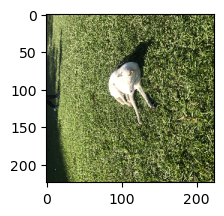

label=森森 | predict=森森


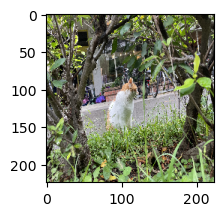

label=牛排 | predict=牛排


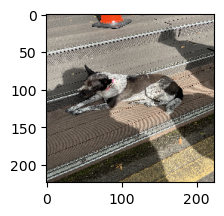

label=森森 | predict=森森


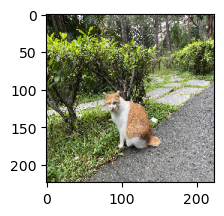

In [59]:
for i in range(4):
    print(f"label={label_classes[labels[i]]} | predict={label_classes[predictions[i]]}")
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.show()

# Convert to tflite

In [ ]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()
# with open("model.tflite", "wb") as fh:
#     fh.write(tflite_model)